In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import LombScargle

plt.style.use('seaborn-whitegrid')

## Convolution

/Users/jakevdp/anaconda/envs/python3.5/lib/python3.5/site-packages/IPython/kernel/__main__.py:11: RuntimeWarning: covariance is not positive-semidefinite.


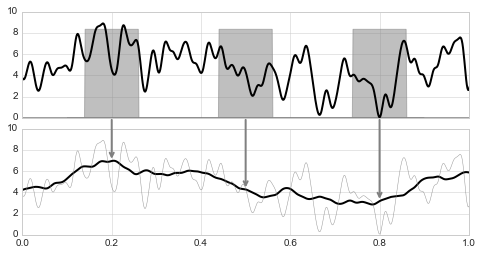

In [5]:
import numpy as np
from matplotlib import pyplot as plt


def generate_smooth_data(size, xlim=(0, 1), coeffs=(0.2, 0.3),
                         smoothing_length=0.01, rseed=0):
    """Generate a smooth random curve between 0 and 1"""
    rng = np.random.RandomState(rseed)
    x = np.linspace(*xlim, num=size)
    C = np.exp(-0.5 * (x - x[:, None]) ** 2 / smoothing_length ** 2)
    y = coeffs[0] + coeffs[1] * rng.multivariate_normal(np.zeros(len(x)), C)
    return x, y
    

x, y = generate_smooth_data(1000, rseed=5423,
                            xlim=(-0.2, 1.2),
                            coeffs=(3, 1.5),
                            smoothing_length=0.01)
y += 2 + np.sin(2 * np.pi * x)  # add larger-scale variation
w = (abs(x - 0.5) < 0.06) / 0.12  # normalized window function
y_w = np.convolve(y, w, mode='same') * (x[1] - x[0])  # convolution

fig, ax = plt.subplots(2, figsize=(8, 4), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.1)

# Plot the data and the smoothed data
ax[0].plot(x, y, '-k', lw=2)
ax[1].plot(x, y_w, '-k', lw=2)
ax[1].plot(x, y, '-', color='gray', alpha=0.8, lw=0.5)

# Plot the window function at several locations
for window_loc in [0.2, 0.5, 0.8]:
    y_loc = y_w[np.searchsorted(x, window_loc)]
    ax[0].fill(x + window_loc - 0.5, w, color='gray', alpha=0.5)
    ax[1].annotate('', (window_loc, y_loc), (window_loc, 0.0),
                   textcoords=ax[0].transData,
                   arrowprops=dict(arrowstyle='->', color='gray', lw=2))

ax[1].yaxis.set_major_locator(plt.MultipleLocator(2))
ax[1].set(xlim=(0, 1), ylim=(0, 10))
fig.savefig('fig04_Convolution_Diagram.pdf')

## Convolution Diagram

/Users/jakevdp/anaconda/envs/python3.5/lib/python3.5/site-packages/IPython/kernel/__main__.py:11: RuntimeWarning: covariance is not positive-semidefinite.


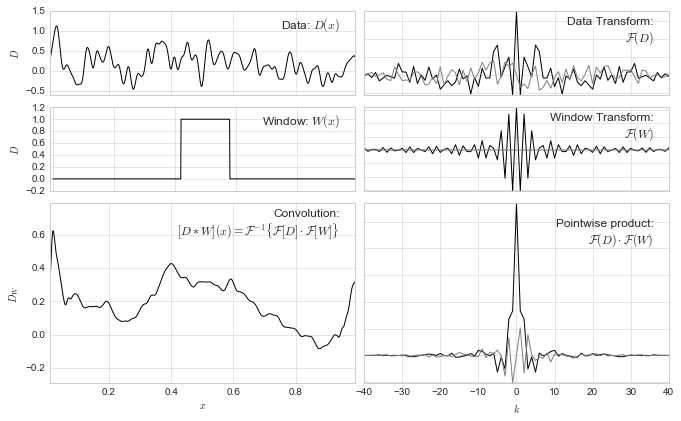

In [6]:
N = 1000
x, y = generate_smooth_data(N, rseed=5793)
w = (abs(x - 0.5) < 0.08).astype(float)

#------------------------------------------------------------
# Perform the convolution
y_norm = np.convolve(np.ones_like(y), w, mode='full')
valid_indices = (y_norm != 0)
y_norm = y_norm[valid_indices]

y_w = np.convolve(y, w, mode='full')[valid_indices] / y_norm

# we can convolve the (symmetric) window with the x-coordinate to
# find the center of the window at each point in the convolution.
x_w = np.convolve(x, w, mode='full')[valid_indices] / y_norm

#------------------------------------------------------------
# Compute the Fourier transforms of the signal and window
y_fft = np.fft.fft(y)
w_fft = np.fft.fft(w)

yw_fft = y_fft * w_fft
yw_final = np.fft.ifft(yw_fft)

#===================================================================
# Now the plots:

def plot_ft(k, F, ax=None, legend=False, text=None):
    """plot the real and imaginary part of a Fourier transform"""
    if ax is None:
        ax = plt.gca()
    F_plot = np.fft.fftshift(F)
    ax.plot(k, F_plot.real, '-', color='black', label='real part')
    ax.plot(k, F_plot.imag, '-', color='gray', label='imag part')
    
    if legend:
        ax.legend(loc='upper left')
    if text:
        ax.text(0.95, 0.9, text, ha='right', va='top', size=12,
                transform=ax.transAxes)
    

#------------------------------------------------------------
# Set up the plots
fig = plt.figure(figsize=(10, 6))
grid = plt.GridSpec(4, 2,
                    left=0.09, bottom=0.09, right=0.95, top=0.95,
                    hspace=0.15, wspace=0.03)

#----------------------------------------
# Upper left panels: plot the data and window function
ax = fig.add_subplot(grid[0, 0])
ax.plot(x, y, '-k')
ax.text(0.95, 0.95, r"Data: $D(x)$",
        ha='right', va='top', transform=ax.transAxes, size=12)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set(ylabel='$D$',
       xlim=(0.01, 0.99),
       ylim=(-0.59, 1.49))

ax = fig.add_subplot(grid[1, 0])
ax.plot(x, w, '-k')
ax.text(0.95, 0.95, r"Window: $W(x)$",
        ha='right', va='top', transform=ax.transAxes, size=12)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set(ylabel='$D$',
       xlim=(-0.01, 0.99),
       ylim=(-0.2, 1.2))

#----------------------------------------
# Lower left panel: plot the convolution
ax = fig.add_subplot(grid[2:, 0])

ax.plot(x_w, y_w, '-k')

ax.text(0.95, 0.95,
        ("Convolution:\n" + r'$[D \ast W](x)$' +
         r'$= \mathcal{F}^{-1}\{\mathcal{F}[D] \cdot \mathcal{F}[W]\}$'),
        ha='right', va='top', transform=ax.transAxes, size=12)

ax.set(xlabel='$x$',
       ylabel='$D_W$',
       xlim=(0.01, 0.99),
       ylim=(-0.29, 0.79))

#----------------------------------------
# Upper right panels: plot the Fourier transforms
N = len(x)
dx = (x[1] - x[0])
k = np.arange(-N/2, N/2) / N / dx

ax1 = fig.add_subplot(grid[:1, 1])
ax2 = fig.add_subplot(grid[1:2, 1])

plot_ft(k, y_fft, ax=ax1, text="Data Transform:\n" + r'$\mathcal{F}(D)$')
plot_ft(k, w_fft, ax=ax2, text="Window Transform:\n" + r'$\mathcal{F}(W)$')

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.axis('tight')
    ax.set_xlim(-40, 40)

#----------------------------------------
# Lower right: plot the product of Fourier transforms
ax = fig.add_subplot(grid[2:, 1])
plot_ft(k, yw_fft, ax=ax,
        text='Pointwise product:\n' + r'$\mathcal{F}(D) \cdot \mathcal{F}(W)$')

ax.axis('tight')
ax.set(xlim=(-40, 40),
       xlabel='$k$')

ax.yaxis.set_major_formatter(plt.NullFormatter())

fig.savefig('fig05_Convolution_Theorem.pdf')

## Windowing Diagram

(-5, 5)

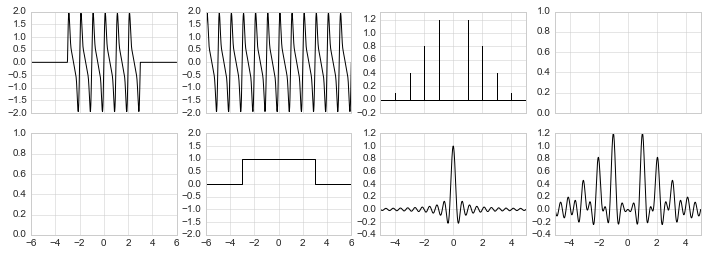

In [3]:
fig, ax = plt.subplots(2, 4, figsize=(12, 4), sharex='col')

x = np.linspace(-6, 6, 1000)

amplitudes = np.array([1.2, 0.8, 0.4, 0.1])
frequencies = np.array([1, 2, 3, 4])

y = amplitudes @ np.sin(2 * np.pi * frequencies[:, None] * x)

yw = y.copy()
yw[abs(x) > 3] = 0
ax[0, 0].plot(x, yw, '-k')

ax[0, 1].plot(x, y, '-k')
ax[0, 2].plot(([-max(frequencies) - 1]
               + sum([3 * [-f] for f in frequencies[::-1]], [])
               + [0]
               + sum([3 * [f] for f in frequencies], [])
               + [max(frequencies) + 1]),
              ([0] + sum([[0, a, 0] for a in amplitudes[::-1]], [])
               + [0] + sum([[0, a, 0] for a in amplitudes], []) + [0]),
              '-k')
ax[0, 2].set_ylim(-0.2, max(amplitudes) * 1.1)

ax[1, 1].plot([-6, -3, -3, 3, 3, 6],
              [0, 0, 1, 1, 0, 0], '-k')
ax[1, 1].set(xlim=(-6, 6), ylim=(-2.0, 2.0))

f = np.linspace(-5, 5, 1000)
ax[1, 2].plot(f, np.sinc(f * 4), '-k')
ax[1, 2].set(xlim=(-5, 5), ylim=(-0.4, 1.2))

ax[1, 3].plot(f, amplitudes @ (np.sinc(4 * (f - frequencies[:, None]))
                               + np.sinc(4 * (f + frequencies[:, None]))),
              '-k')
ax[1, 3].set_xlim(-5, 5)